(howto_debugging)=
# How to debug a model

:::{post} August 2, 2022
:tags: debugging, aesara
:category: beginner
:author: Thomas Wiecki, Igor Kuvychko
:::

## Introduction
There are various levels on which to debug a model. One of the simplest is to just print out the values that different variables are taking on.

Because `PyMC` uses `Aesara` expressions to build the model, and not functions, there is no way to place a `print` statement into a likelihood function. Instead, you can use the `aesara.printing.Print` class to print intermediate values.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 8927

### How to print intermediate values of `Aesara` functions
Since `Aesara` functions are compiled to C, you have to use `aesara.printing.Print` class to print intermediate values (imported  below as `Print`). Python `print` function will not work. Below is a simple example of using `Print`. For more information, see {ref}`Debugging Aesara <aesara:debug_faq>`.

In [3]:
import aesara.tensor as at

from aesara import function
from aesara.printing import Print

In [4]:
x = at.dvector("x")
y = at.dvector("y")
func = function([x, y], 1 / (x - y))
func([1, 2, 3], [1, 0, -1])

array([ inf, 0.5 , 0.25])

To see what causes the `inf` value in the output, we can print intermediate values of $(x-y)$ using `Print`. `Print` class simply passes along its caller but prints out its value along a user-define message:

In [5]:
z_with_print = Print("x - y = ")(x - y)
func_with_print = function([x, y], 1 / z_with_print)
func_with_print([1, 2, 3], [1, 0, -1])

x - y =  __str__ = [0. 2. 4.]


array([ inf, 0.5 , 0.25])

`Print` reveals the root cause: $(x-y)$ takes a zero value when $x=1, y=1$, causing the `inf` output.

### How to capture `Print` output for further analysis

When we expect many rows of output from `Print`, it can be desirable to redirect the output to a string buffer and access the values later on (thanks to **Lindley Lentati** for inspiring this example). Here is a toy example using Python `print` function:

In [6]:
import sys

from io import StringIO

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

for i in range(5):
    print(f"Test values: {i}")

output = mystdout.getvalue().split("\n")
sys.stdout = old_stdout  # setting sys.stdout back
output

['Test values: 0',
 'Test values: 1',
 'Test values: 2',
 'Test values: 3',
 'Test values: 4',
 '']

### Troubleshooting a toy PyMC model

In [7]:
rng = np.random.default_rng(RANDOM_SEED)
x = rng.normal(size=100)

with pm.Model() as model:
    # priors
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.Normal("sd", mu=0, sigma=1)

    # setting out printing for mu and sd
    mu_print = Print("mu")(mu)
    sd_print = Print("sd")(sd)

    # likelihood
    obs = pm.Normal("obs", mu=mu_print, sigma=sd_print, observed=x)

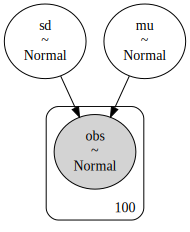

In [8]:
pm.model_to_graphviz(model)

In [9]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(5, step, tune=0, chains=1, progressbar=False, random_seed=RANDOM_SEED)

Only 5 samples in chain.


sd __str__ = 0.0
mu __str__ = 0.0


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mu': array(0.), 'sd': array(0.)}

Initial evaluation results:
{'mu': -0.92, 'sd': -0.92, 'obs': -inf}

Exception handling of PyMC v4 has improved, so now SamplingError exception prints out the intermediate values of `mu` and `sd` which led to likelihood of `-inf`. However, this technique of printing intermediate values with `aeasara.printing.Print` can be valuable in more complicated cases.

### Bringing it all together

In [10]:
rng = np.random.default_rng(RANDOM_SEED)
y = rng.normal(loc=5, size=20)

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    a = pm.Normal("a", mu=0, sigma=10, initval=0.1)
    b = pm.Normal("b", mu=0, sigma=10, initval=0.1)
    sd_print = Print("Delta")(a / b)
    obs = pm.Normal("obs", mu=mu, sigma=sd_print, observed=y)

    # limiting number of samples and chains to simplify output
    trace = pm.sample(draws=10, tune=0, chains=1, progressbar=False, random_seed=RANDOM_SEED)

output = mystdout.getvalue()
sys.stdout = old_stdout  # setting sys.stdout back

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, a, b]
Sampling 1 chain for 0 tune and 10 draw iterations (0 + 10 draws total) took 1 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Users\igork\AppData\Local\Temp\ipykernel_14804\1992602661.py:15: UserWarning: The number of samples is too small to check convergence reliably.
  trace = pm.sample(draws=10, tune=0, chains=1, progressbar=False, random_seed=RANDOM_SEED)


In [11]:
output

'Delta __str__ = -85.74093608165128\nDelta __str__ = -9.182002291671038\nDelta __str__ = 0.10737295473067673\nDelta __str__ = 0.10737295473067673\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315734173890055\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.312485782438435\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.314669656412736\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.31581619157038\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315114719133609\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.31511040479387\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.314077394936474\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.313673830463395\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.31561025339713\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.31526569370057\nDelta __str__ = 0.10737295473067673\nDelta __str__ = 0.10737295473067673\nDelta __str__ = 0.10737295473067673\nDelta __str__ = 

Raw output is a bit messy and requires some cleanup and formatting to convert to `numpy.ndarray`. In the example below regex is used to clean up the output, and then it is evaluated with `eval` to give a list of floats. Code below also works with higher-dimensional outputs (in case you want to experiment with different models).

In [12]:
import re

# output cleanup and conversion to numpy array
# this is code accepts more complicated inputs
pattern = re.compile("Delta __str__ = ")
output = re.sub(pattern, " ", output)
pattern = re.compile("\\s+")
output = re.sub(pattern, ",", output)
pattern = re.compile(r"\[,")
output = re.sub(pattern, "[", output)
output += "]"
output = "[" + output[1:]
output = eval(output)
output = np.array(output)

In [13]:
output

array([-85.74093608,  -9.18200229,   0.10737295,   0.10737295,
         0.10737295,  -9.31573417,   0.10737295,  -9.31248578,
         0.10737295,  -9.31466966,   0.10737295,  -9.31581619,
         0.10737295,  -9.31511472,   0.10737295,  -9.3151104 ,
         0.10737295,  -9.31407739,   0.10737295,  -9.31367383,
         0.10737295,  -9.31561025,   0.10737295,  -9.31526569,
         0.10737295,   0.10737295,   0.10737295,   0.10737295,
         0.10737295,   0.10737295,   0.10737295,   0.10737295,
         0.10737295,   0.10737295])

Notice that we requested 5 draws, but got 34 sets of $a/b$ values. The reason is that for each iteration, all proposed values are printed (not just the accepted values). Negative values are clearly problematic.

In [14]:
output.shape

(34,)

## Authors

* Authored by Thomas Wiecki in July, 2016
* Updated by Igor Kuvychko in August, 2022 ([pymc#406] (https://github.com/pymc-devs/pymc-examples/pull/406))

## Watermark

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,xarray

Last updated: Tue Aug 02 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

aesara: 2.7.5
xarray: 2022.3.0

matplotlib: 3.5.2
aesara    : 2.7.5
numpy     : 1.23.0
arviz     : 0.12.1
sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 06:57:19) [MSC v.1929 64 bit (AMD64)]
re        : 2.2.1
pandas    : 1.4.3
pymc      : 4.1.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::